<a href="https://colab.research.google.com/github/hyunwookim129/pneumonia_detection_GradCAM/blob/main/pneumonia_upgrade_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:43<00:00, 23.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import shutil

# For computing class weights
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam





In [3]:
# For Google Drive mounting (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



=== Checking training folder structure ===
Classes in train folder: ['NORMAL', 'PNEUMONIA']
Number of NORMAL images:    1341
Number of PNEUMONIA images: 3875

=== Displaying sample NORMAL & PNEUMONIA images ===


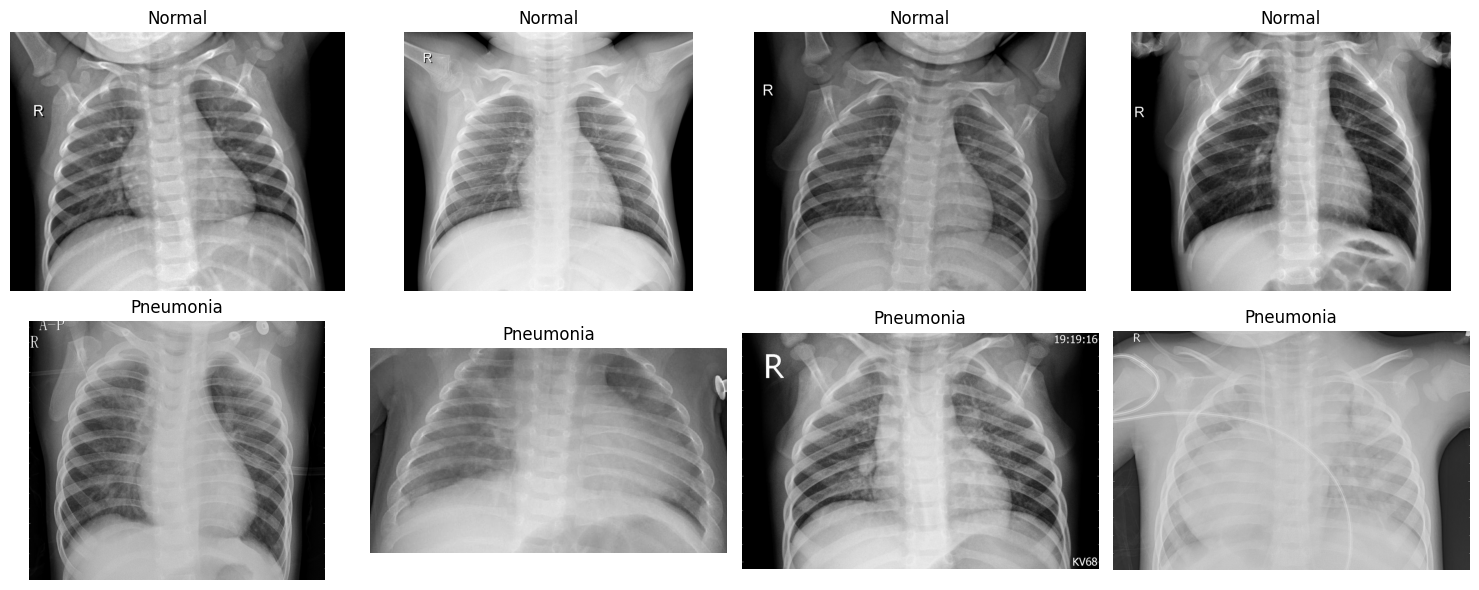


=== Merging original 'val' folder into 'train', then re-splitting ===
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training samples:   4187
Validation samples: 1045
Train - NORMAL: 1080
Val   - NORMAL: 269
Train - PNEUMONIA: 3107
Val   - PNEUMONIA: 776

=== Computing class weights ===
Class Weights: {0: 1.938425925925926, 1: 0.6738010943031864}


In [4]:
# Define dataset directories
train_image_path = pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train')
val_image_path   = pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val')
test_image_path  = pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test')

print("\n=== Checking training folder structure ===")
train_classes = os.listdir(train_image_path)
print("Classes in train folder:", train_classes)

normal_images     = os.listdir(train_image_path / "NORMAL")
pneumonia_images  = os.listdir(train_image_path / "PNEUMONIA")
num_normal_images = len(normal_images)
num_pneumonia_img = len(pneumonia_images)
print(f"Number of NORMAL images:    {num_normal_images}")
print(f"Number of PNEUMONIA images: {num_pneumonia_img}")

print("\n=== Displaying sample NORMAL & PNEUMONIA images ===")
sample_normal_images     = normal_images[:4]
sample_pneumonia_images  = pneumonia_images[:4]

fig, axes = plt.subplots(2, 4, figsize=(15, 6))
for i, img_name in enumerate(sample_normal_images):
    img_path = train_image_path / "NORMAL" / img_name
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    ax  = axes[0, i]
    ax.imshow(img, cmap='gray')
    ax.set_title("Normal")
    ax.axis('off')

for i, img_name in enumerate(sample_pneumonia_images):
    img_path = train_image_path / "PNEUMONIA" / img_name
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    ax  = axes[1, i]
    ax.imshow(img, cmap='gray')
    ax.set_title("Pneumonia")
    ax.axis('off')

plt.tight_layout()
plt.show()


print("\n=== Merging original 'val' folder into 'train', then re-splitting ===")
for folder in ['NORMAL', 'PNEUMONIA']:
    val_folder   = val_image_path / folder
    train_folder = train_image_path / folder
    for img_file in os.listdir(val_folder):
        shutil.move(str(val_folder / img_file), str(train_folder))

# Now we re-split the combined train data into new train & validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)
test_datagen = ImageDataGenerator(rescale=1./255)


batch_size = 16
img_size   = (150, 150)

train_generator = train_datagen.flow_from_directory(
    train_image_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_image_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_image_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples:   {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

# Check class distribution in train/val
train_labels = train_generator.labels
val_labels   = val_generator.labels
train_bincnt = np.bincount(train_labels)
val_bincnt   = np.bincount(val_labels)
class_names  = list(train_generator.class_indices.keys())

for i, cls_name in enumerate(class_names):
    print(f"Train - {cls_name}: {train_bincnt[i]}")
    print(f"Val   - {cls_name}: {val_bincnt[i]}")


print("\n=== Computing class weights ===")
cw_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(cw_values))
print("Class Weights:", class_weights_dict)

In [6]:
# Define input shape
input_shape = (150, 150, 3)

# Input layer
inputs = Input(shape=input_shape)

# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu', padding='same', name="conv1")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', name="conv2")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', name="conv3")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten layer
x = Flatten()(x)

# Fully connected layers
x = Dense(128, activation='relu', name="fc1")(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name="fc2")(x)

# Output layer (Binary Classification)
outputs = Dense(1, activation='sigmoid', name="output")(x)

# Create model
model = Model(inputs, outputs, name="GradCAM_Model")

# Enable mixed precision for faster GPU training
mixed_precision.set_global_policy("mixed_float16")

# Optimizer with Loss Scaling for mixed precision training
opt = mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.0001))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()




Model: "GradCAM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,411,009 (20.64 MB)

 Trainable params: 5,410,561 (20.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce learning rate when validation loss stops improving
    factor=0.5,          # Reduce by 50% (lr *= 0.5)
    patience=3,          # Wait 3 epochs before reducing
    min_lr=1e-6,         # Minimum learning rate
    verbose=1
)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    batch_size=32,  # Adjust batch size based on available GPU memory
    class_weight=class_weights_dict,  # Handles class imbalance
    callbacks=[early_stopping , lr_scheduler],
    verbose=1
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 302ms/step - accuracy: 0.6567 - loss: 2.3911 - val_accuracy: 0.7426 - val_loss: 16.3921 - learning_rate: 0.0010
Epoch 2/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 70s 264ms/step - accuracy: 0.7083 - loss: 0.6176 - val_accuracy: 0.7426 - val_loss: 14.4995 - learning_rate: 0.0010
Epoch 3/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 81s 258ms/step - accuracy: 0.7155 - loss: 0.5496 - val_accuracy: 0.8134 - val_loss: 0.5412 - learning_rate: 0.0010
Epoch 4/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 83s 261ms/step - accuracy: 0.7464 - loss: 0.4277 - val_accuracy: 0.7435 - val_loss: 3.2008 - learning_rate: 0.0010
Epoch 5/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 70s 260ms/step - accuracy: 0.6362 - loss: 0.5205 - val_accuracy: 0.7474 - val_loss: 5.4638 - learning_rate: 0.0010
Epoch 6/25
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6534 - loss: 0.4875
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 292ms/step - accuracy: 0.6534 - loss:

In [8]:
# Save the trained model
model.save("/content/drive/My Drive/pneumonia_model.keras")

# Load the model for Grad-CAM
loaded_model = tf.keras.models.load_model("/content/drive/My Drive/pneumonia_model.keras")

print("✅ Model saved and loaded successfully!")

✅ Model saved and loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 42 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv2", pred_index=None):
    """
    Generates a Grad-CAM heatmap with improved gradient scaling and contrast.
    """
    # Get the convolutional layer & model output
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to record operations
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)

        # Select class index (ensure it's correct for binary/multi-class cases)
        if pred_index is None:
            if preds.shape[-1] == 1:  # Binary classification
                pred_index = 0
            else:
                pred_index = tf.argmax(preds[0])

        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Check if gradients are None
    if grads is None:
        raise ValueError(f"❌ Gradients are None. The model might not be built correctly, or the selected layer '{last_conv_layer_name}' may not support backpropagation.\n"
                         "💡 Try selecting an earlier convolutional layer (e.g., conv2 instead of conv3).")

    # Normalize gradients (avoid vanishing/exploding values)
    grads = (grads - tf.reduce_mean(grads)) / (tf.math.reduce_std(grads) + 1e-8)

    # Compute global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight each feature map by importance
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize the heatmap for better contrast
    heatmap = (heatmap - np.percentile(heatmap, 5)) / (np.percentile(heatmap, 99) - np.percentile(heatmap, 5) + 1e-8)
    heatmap = np.clip(heatmap, 0, 1)
    heatmap = np.uint8(255 * heatmap)  # Convert to 8-bit for visualization

    return heatmap


def show_gradcam(original_img, heatmap, alpha=0.6):
    """
    Overlays a Grad-CAM heatmap on the original image.
    """
    # Apply improved colormap for better contrast
    jet_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_TURBO)

    # Resize heatmap to match original image size
    jet_heatmap = cv2.resize(jet_heatmap, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Normalize original image to [0, 255] range for consistent brightness
    original_img = (original_img - np.min(original_img)) / (np.max(original_img) - np.min(original_img) + 1e-8) * 255
    original_img = original_img.astype(np.uint8)

    # Convert images to float32 for proper blending
    original_img = original_img.astype(np.float32)
    jet_heatmap = jet_heatmap.astype(np.float32)

    # Blend heatmap with original image (adjust transparency)
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, jet_heatmap, alpha, 0)

    return np.uint8(superimposed_img)  # Convert back to uint8 for display


In [26]:
# Define test image directory (PNEUMONIA folder)
test_pneumonia_dir = Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA')

# Verify if directory exists
if not test_pneumonia_dir.exists():
    raise ValueError(f"❌ ERROR: Test image folder not found at {test_pneumonia_dir}")

# Get a list of all images in the folder (JPEG, JPG, PNG)
image_files = list(test_pneumonia_dir.glob("*.jpeg")) + list(test_pneumonia_dir.glob("*.jpg")) + list(test_pneumonia_dir.glob("*.png"))

# Check if there are any images
if not image_files:
    raise ValueError(f"❌ ERROR: No images found in {test_pneumonia_dir}")

# Select the first image
test_image1_path = str(image_files[10])
print(f"Using test image: {test_image1_path}")
# Load the selected image

original_img = cv2.imread(test_image1_path)

# Ensure OpenCV successfully loads the image
if original_img is None:
    raise ValueError(f"❌ ERROR: Could not load image at {test_image_path}. Check if the file exists!")

# Convert BGR to RGB (Matplotlib expects RGB)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Resize image to model input size (150x150)
resized_img = cv2.resize(original_img_rgb, (150, 150))

# Prepare for model input (Normalize & Add batch dimension)
input_tensor = np.expand_dims(resized_img, axis=0) / 255.0

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person1614_virus_2800.jpeg


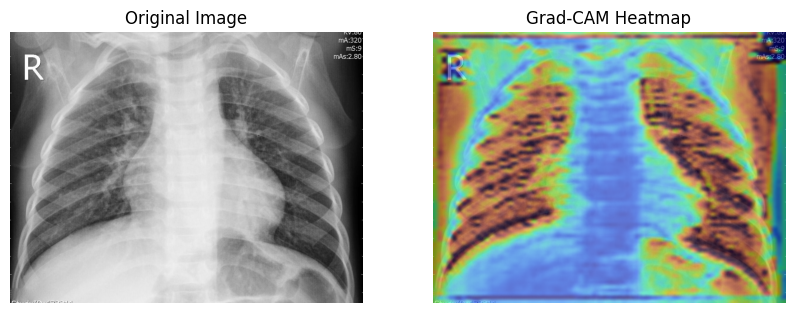

Grad-CAM Generated Successfully!


In [27]:
# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(input_tensor, loaded_model)

# Overlay Grad-CAM heatmap on original image
superimposed_img = show_gradcam(original_img_rgb, heatmap)

# Display results
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_img_rgb)
plt.axis("off")

# Grad-CAM Visualization
plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(superimposed_img.astype(np.uint8))
plt.axis("off")

plt.show()

print("Grad-CAM Generated Successfully!")

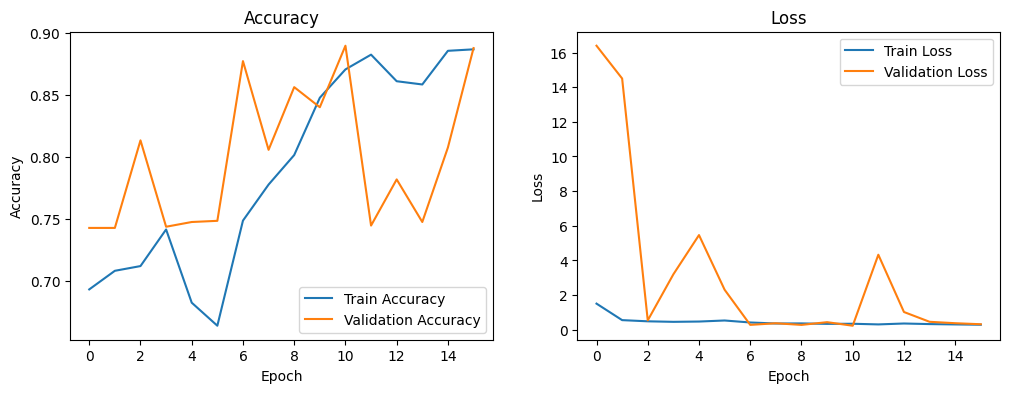

In [28]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.87      0.67      0.76       234
   PNEUMONIA       0.83      0.94      0.88       390

    accuracy                           0.84       624
   macro avg       0.85      0.80      0.82       624
weighted avg       0.84      0.84      0.83       624

Overall Test Accuracy: 0.84
AUC-ROC: 0.92
AUC-PR: 0.95
Confusion Matrix:


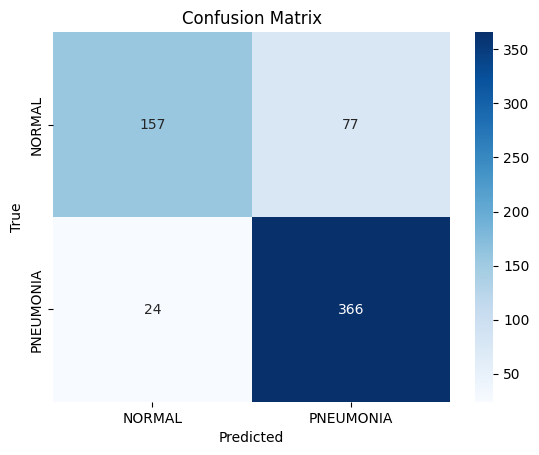

Sensitivity (Recall for PNEUMONIA): 0.94
Specificity (Recall for NORMAL): 0.67


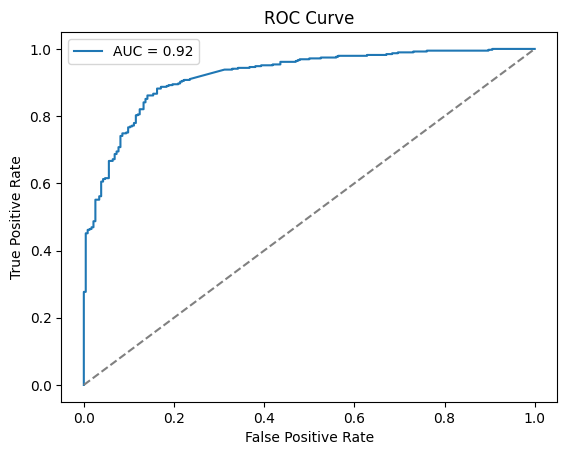

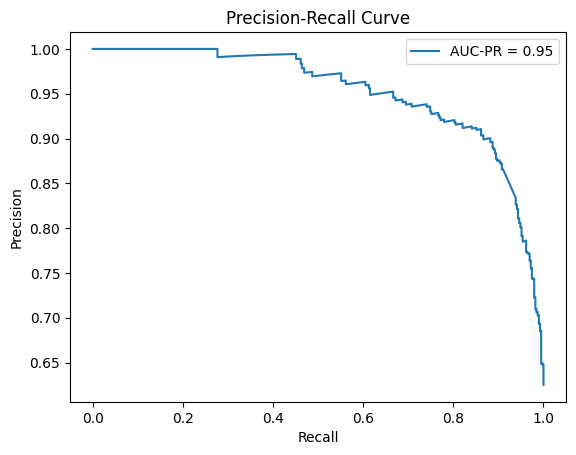

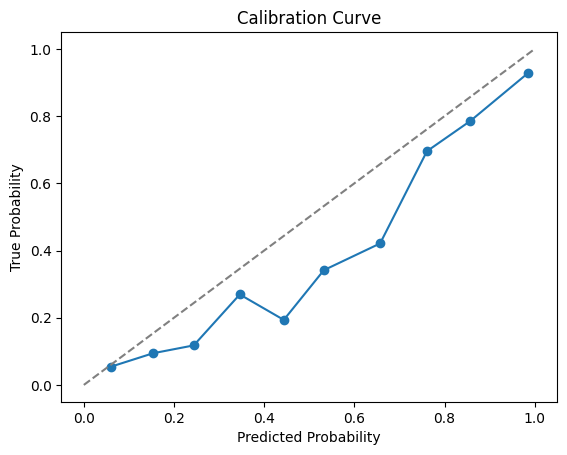

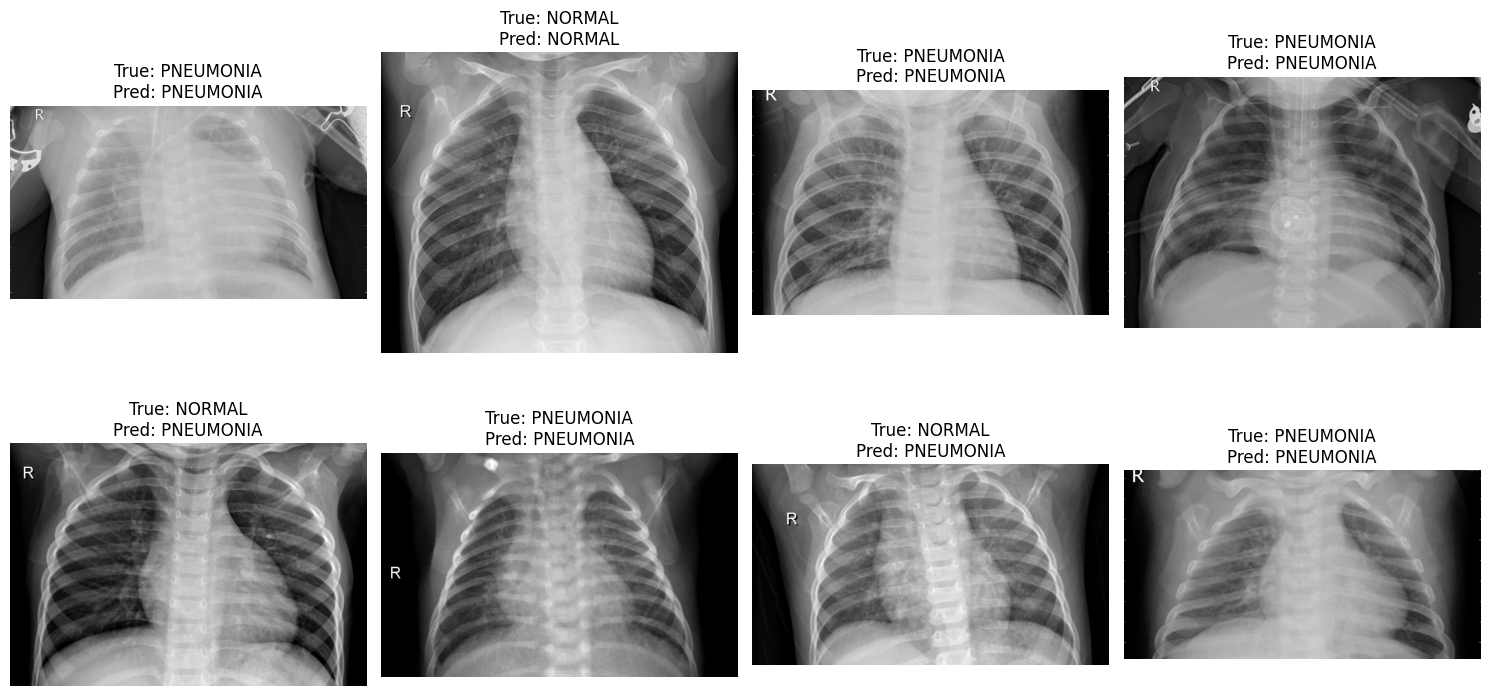

In [29]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc,roc_curve
from sklearn.calibration import calibration_curve
import seaborn as sns

# Enhanced function
def test_and_visualize_with_metrics(model, test_generator):
    # Get predictions and true labels
    predictions = model.predict(test_generator)
    y_true = test_generator.classes  # True labels
    y_pred = (predictions > 0.5).astype(int)  # Predicted labels

    # Class labels
    class_indices = test_generator.class_indices
    class_names = list(class_indices.keys())

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Overall accuracy
    from sklearn.metrics import accuracy_score
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Test Accuracy: {overall_accuracy:.2f}")

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, predictions)
    print(f"AUC-ROC: {auc_roc:.2f}")

    # AUC-PR
    precision, recall, _ = precision_recall_curve(y_true, predictions)
    auc_pr = auc(recall, precision)
    print(f"AUC-PR: {auc_pr:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Sensitivity and Specificity
    TP = cm[1, 1]  # True Positives
    FN = cm[1, 0]  # False Negatives
    FP = cm[0, 1]  # False Positives
    TN = cm[0, 0]  # True Negatives

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    print(f"Sensitivity (Recall for PNEUMONIA): {sensitivity:.2f}")
    print(f"Specificity (Recall for NORMAL): {specificity:.2f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal for random guessing
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.2f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y_true, predictions, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.show()

    # Visualize random sample predictions
    visualize_results_with_generator(test_generator, predictions, class_names)

# Visualization function remains the same
def visualize_results_with_generator(test_generator, predictions, class_names):
    # Display a few images with predictions
    filepaths = test_generator.filepaths
    true_labels = test_generator.classes
    predicted_labels = (predictions > 0.5).astype(int)

    # Select a few images for visualization
    sample_indices = np.random.choice(len(filepaths), size=8, replace=False)
    sample_images = [filepaths[i] for i in sample_indices]
    sample_predictions = [predicted_labels[i] for i in sample_indices]
    sample_true_labels = [true_labels[i] for i in sample_indices]

    # Plot images with predictions
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    for i, ax in enumerate(axes.flat):
        img = cv2.imread(sample_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_label = class_names[sample_true_labels[i]]
        pred_label = class_names[sample_predictions[i][0]]

        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the enhanced function
test_and_visualize_with_metrics(model, test_generator)